Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12778379.89it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 344538.76it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3207249.44it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5525095.35it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/30], Loss: 1459.5958
Epoch [6/30], Loss: 1288.5805
Epoch [11/30], Loss: 1203.7673
Epoch [16/30], Loss: 1136.1069
Epoch [21/30], Loss: 1079.2521
Epoch [26/30], Loss: 1031.3261


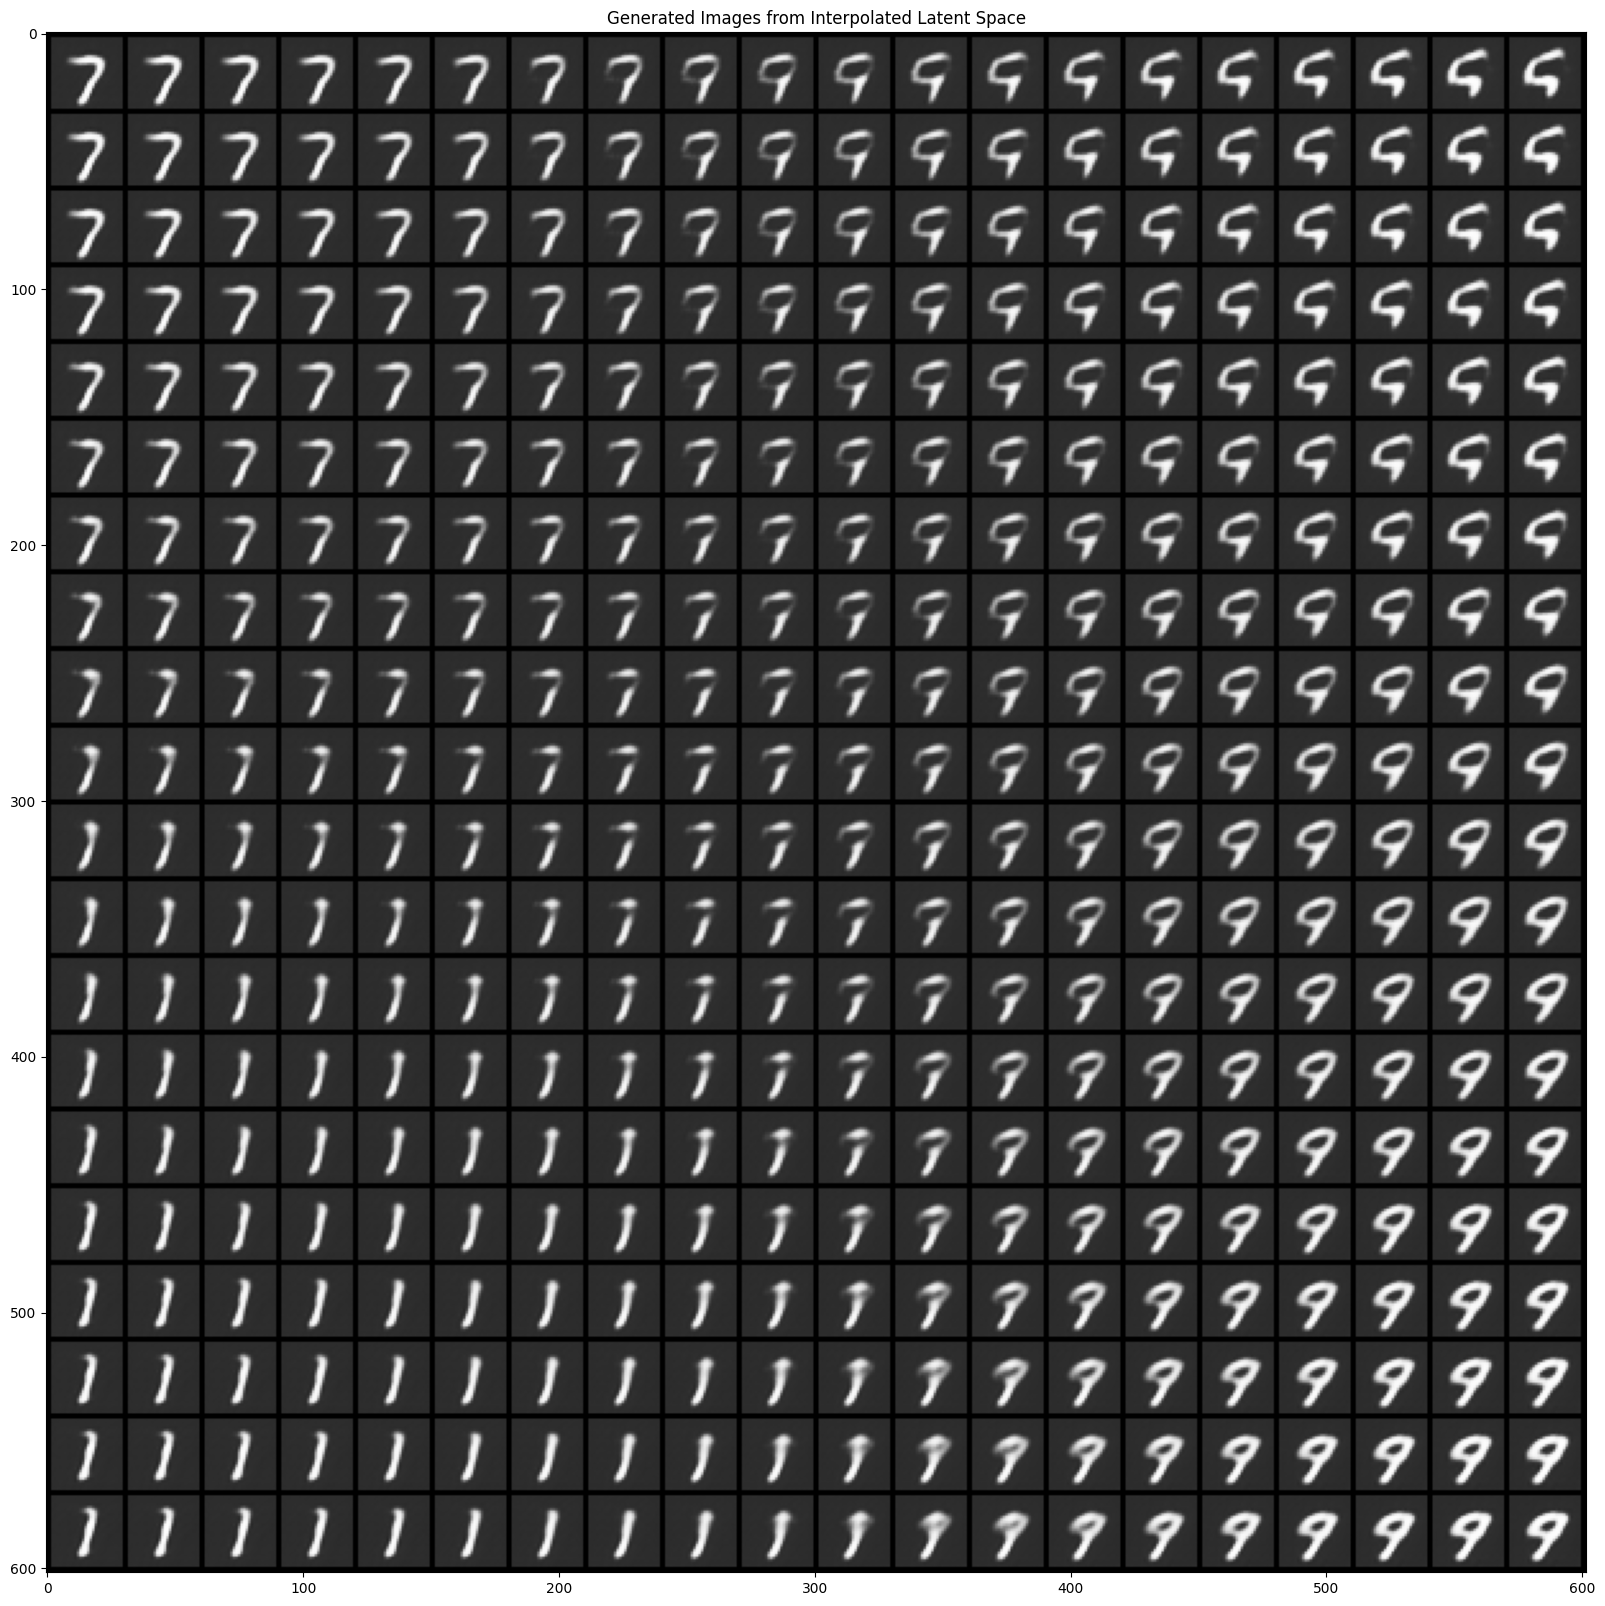

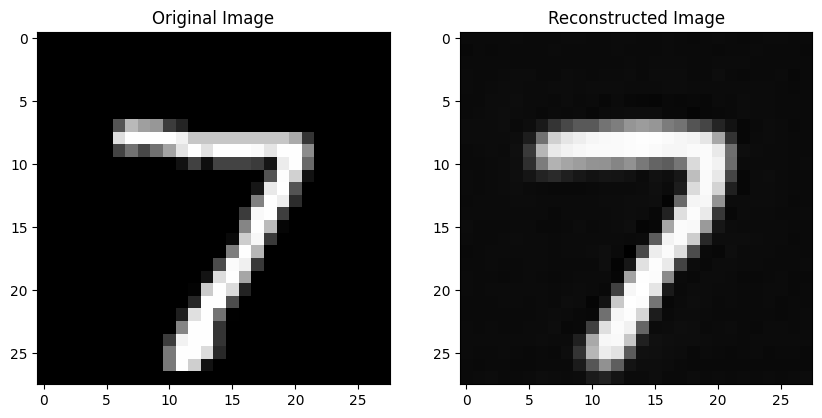

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision

class ConvVAE(nn.Module):
    def __init__(self, in_size, in_channels, latent_dim, hidden_channels: list, dropout_rate=0.1):
        super().__init__()
        self.in_size = in_size
        self.in_channels = in_channels
        self.z_dim = latent_dim

        if not hidden_channels:
            raise ValueError("hidden_channels list cannot be empty")
        if in_size % (2 ** len(hidden_channels)) != 0:
            raise ValueError(f"in_size {in_size} must be divisible by {2 ** len(hidden_channels)}")

        """Constructing the encoder"""
        encoder_layers = [
            nn.Sequential(
                nn.Conv2d(self.in_channels, hidden_channels[0], kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(hidden_channels[0]),
                nn.ReLU(),
                nn.Dropout2d(dropout_rate)
            )
        ]

        for i in range(len(hidden_channels) - 1):
            encoder_layers.append(
                nn.Sequential(
                    nn.Conv2d(hidden_channels[i], hidden_channels[i + 1], kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(hidden_channels[i + 1]),
                    nn.ReLU(),
                    nn.Dropout2d(dropout_rate)
                )
            )

        last_ir_size = in_size // (2 ** len(hidden_channels))
        flattened_dim = hidden_channels[-1] * last_ir_size * last_ir_size

        encoder_layers.append(nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_dim, 2 * self.z_dim),
            nn.BatchNorm1d(2 * self.z_dim),
            nn.Dropout(dropout_rate)
        ))
        self.encoder = nn.Sequential(*encoder_layers)

        """Constructing the decoder"""
        decoder_layers = [
            nn.Sequential(
                nn.Linear(self.z_dim, flattened_dim),
                nn.BatchNorm1d(flattened_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
        ]

        decoder_layers.append(
            nn.Sequential(
                nn.Unflatten(1, (hidden_channels[-1], last_ir_size, last_ir_size))
            )
        )

        for i in range(len(hidden_channels) - 1, 0, -1):
            decoder_layers.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_channels[i], hidden_channels[i - 1], kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(hidden_channels[i - 1]),
                    nn.ReLU(),
                    nn.Dropout2d(dropout_rate)
                )
            )

        decoder_layers.append(
            nn.Sequential(
                nn.ConvTranspose2d(hidden_channels[0], self.in_channels, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(self.in_channels),
                nn.Sigmoid()
            )
        )

        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        x = self.encoder(x)
        mu, log_var = x.chunk(2, dim=1)
        return mu, log_var

    @staticmethod
    def reparameterize(mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


def loss_func(mu, log_var, x_hat, x):
    MSE = F.mse_loss(x_hat, x, reduction='sum')
    KL = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)
    return torch.mean(KL + MSE)


batch_size = 1024
learning_rate = 0.0005
num_epochs = 30
latent_dim = 20  
hidden_channels = [16, 32]
dropout_rate = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = ConvVAE(in_size=28, in_channels=1, latent_dim=latent_dim, hidden_channels=hidden_channels, dropout_rate=dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        recon_images, mu, log_var = model(images)

        loss = loss_func(mu, log_var, recon_images, images)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    if(epoch%5==0):
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss / len(train_loader.dataset):.4f}")

model.eval()
with torch.no_grad():
    # Step 1: Get the first batch of images from the test_loader
    images, labels = next(iter(test_loader))  # Get the first batch of images and labels
    
    # Step 2: Select the 1st, 4th, 9th, and 10th images from the batch
    selected_images = [images[i] for i in [0, 2, 8, 9]]  # Index 0 for 1st, 3 for 4th, 8 for 9th, 9 for 10th
    
    # Step 3: Move the selected images to the device (GPU or CPU)
    selected_images = [img.unsqueeze(0).to(device) for img in selected_images]  # Add batch dimension

    # Step 4: Encode the selected images using the VAE model
    mu_list = []
    log_var_list = []
    for img in selected_images:
        mu, log_var = model.encode(img)  # Encode the image to get the mean (mu) and log variance (log_var)
        mu_list.append(mu)
        log_var_list.append(log_var)
    
    # Step 5: Optionally, reparameterize to get latent samples (z)
    z_list = [model.reparameterize(mu, log_var) for mu, log_var in zip(mu_list, log_var_list)]
    
    # Step 2: Interpolate between the four points and create a grid
    num_points = 20  # Define how many points to generate between each pair
    grid_points = []

    for i in range(num_points):
        alpha = i / (num_points - 1)
        for j in range(num_points):
            beta = j / (num_points - 1)
            # Interpolate between the four corner points
            z = (1 - alpha) * (1 - beta) * z_list[0] + alpha * (1 - beta) * z_list[1] + (1 - alpha) * beta * z_list[2] + alpha * beta * z_list[3]
            grid_points.append(z)
    
    # Step 3: Convert the list of grid points into a tensor
    grid_points = torch.cat(grid_points, dim=0)

    # Step 4: Decode the latent vectors into images
    generated_images = model.decode(grid_points).cpu()

    # Step 5: Visualize the generated images in a grid
    grid_img = torchvision.utils.make_grid(generated_images, nrow=num_points)
    plt.figure(figsize=(20, 20))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title("Generated Images from Interpolated Latent Space")
    plt.show()

    # Step 6: Visualize original and reconstructed images from the test set
    sample_image, _ = next(iter(test_loader))
    sample_image = sample_image.to(device)

    recon_image, _, _ = model(sample_image)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(sample_image[0].cpu().squeeze(), cmap='gray')
    ax[0].set_title("Original Image")
    ax[1].imshow(recon_image[0].cpu().squeeze(), cmap='gray')
    ax[1].set_title("Reconstructed Image")
    plt.show()

In [2]:
def beta_vae_loss(mu, log_var, x_hat, x, beta=1.0):
    # Reconstruction loss (Mean Squared Error)
    reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')
    
    # KL Divergence loss
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)
    
    # Total Loss
    total_loss = reconstruction_loss + beta * kl_divergence.mean()
    
    return total_loss

Training with Beta=0.1
Epoch [1/30], Loss: 1470.0444
Epoch [6/30], Loss: 1284.5692
Epoch [11/30], Loss: 1201.3657
Epoch [16/30], Loss: 1134.4456
Epoch [21/30], Loss: 1078.3213
Epoch [26/30], Loss: 1030.7795


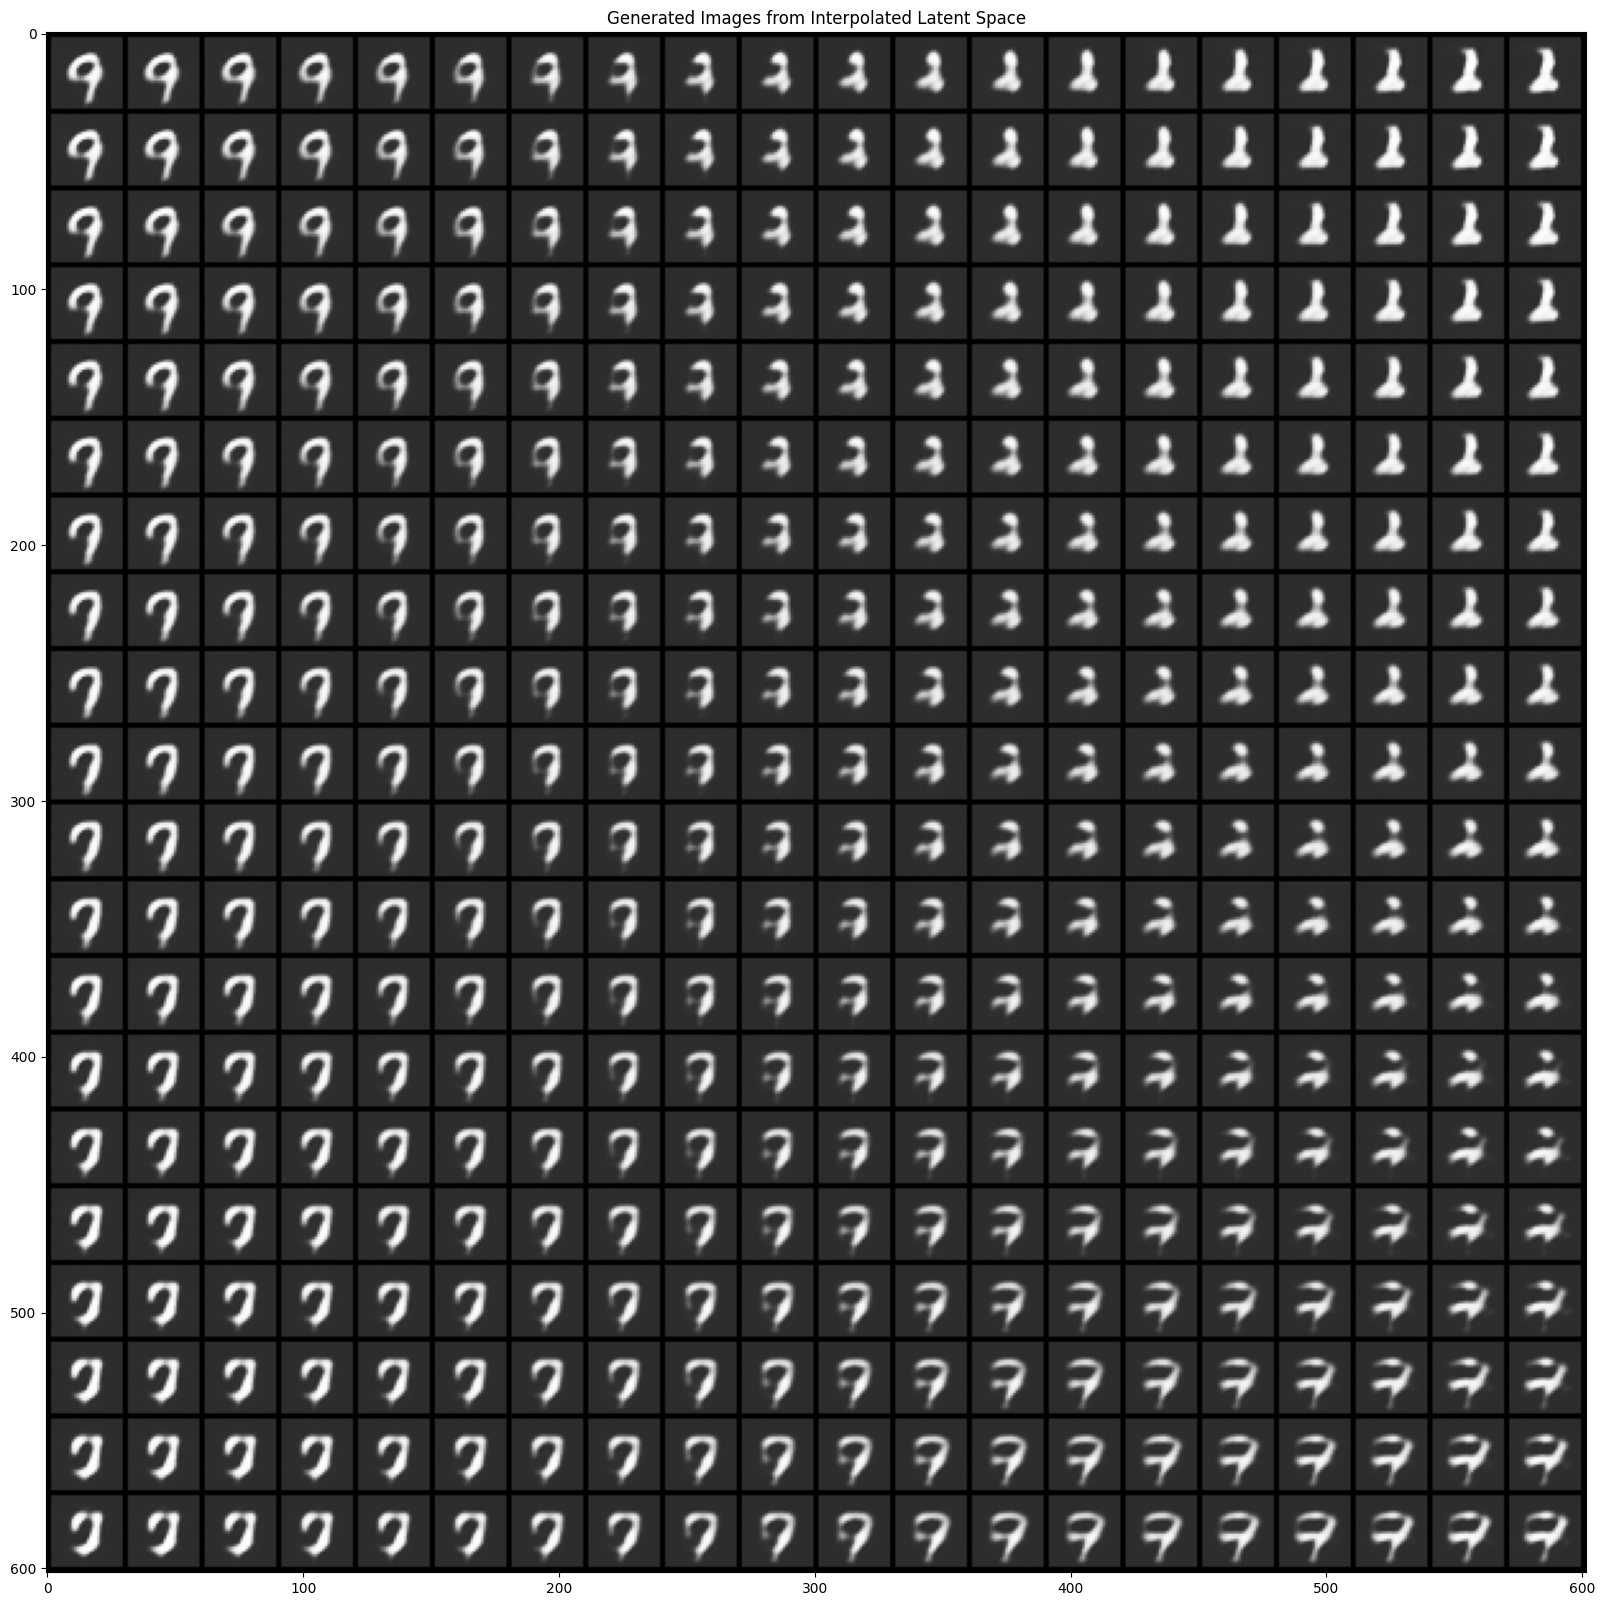

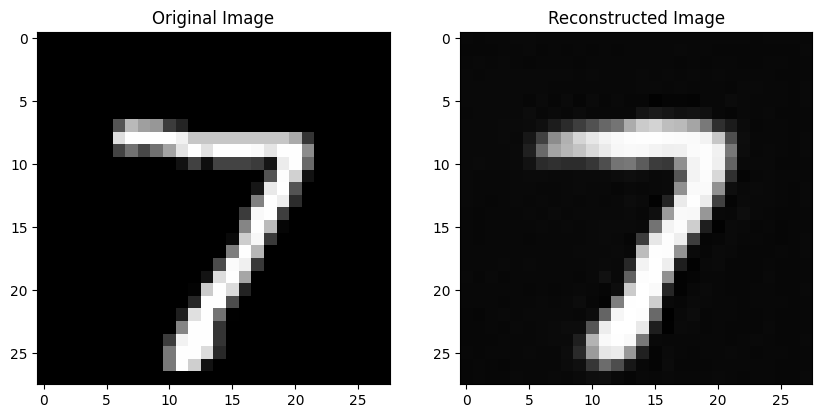

Training with Beta=2.0
Epoch [1/30], Loss: 1463.0540
Epoch [6/30], Loss: 1289.1959
Epoch [11/30], Loss: 1203.5411
Epoch [16/30], Loss: 1135.8622
Epoch [21/30], Loss: 1079.3272
Epoch [26/30], Loss: 1031.2927


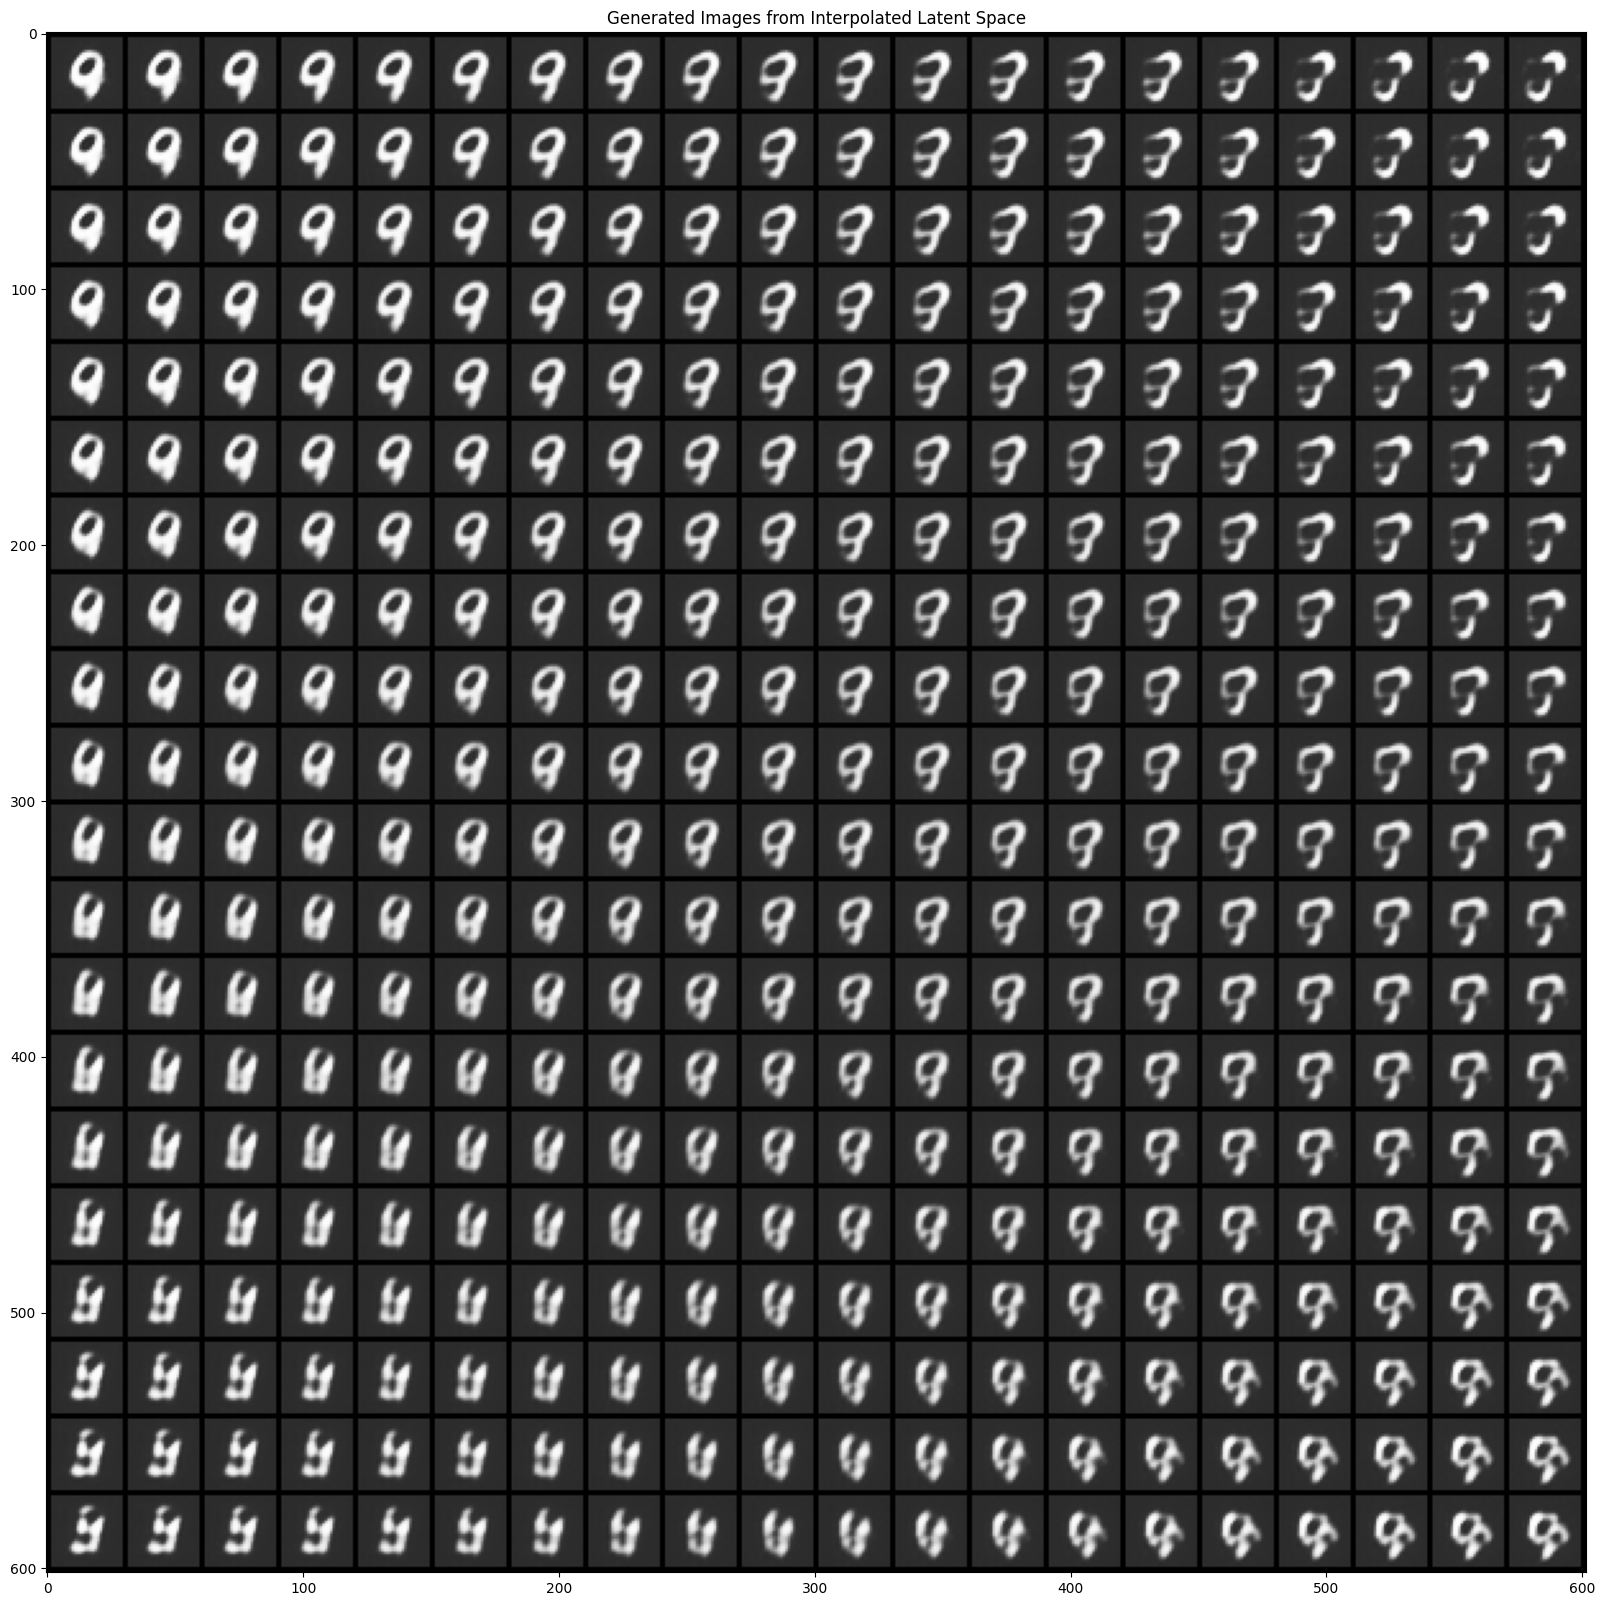

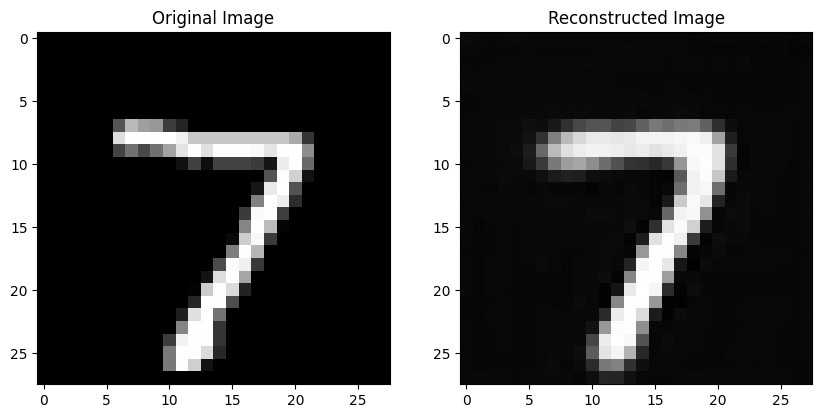

Training with Beta=5.0
Epoch [1/30], Loss: 1467.6028
Epoch [6/30], Loss: 1286.8176
Epoch [11/30], Loss: 1202.8300
Epoch [16/30], Loss: 1136.0115
Epoch [21/30], Loss: 1079.6087
Epoch [26/30], Loss: 1031.7759


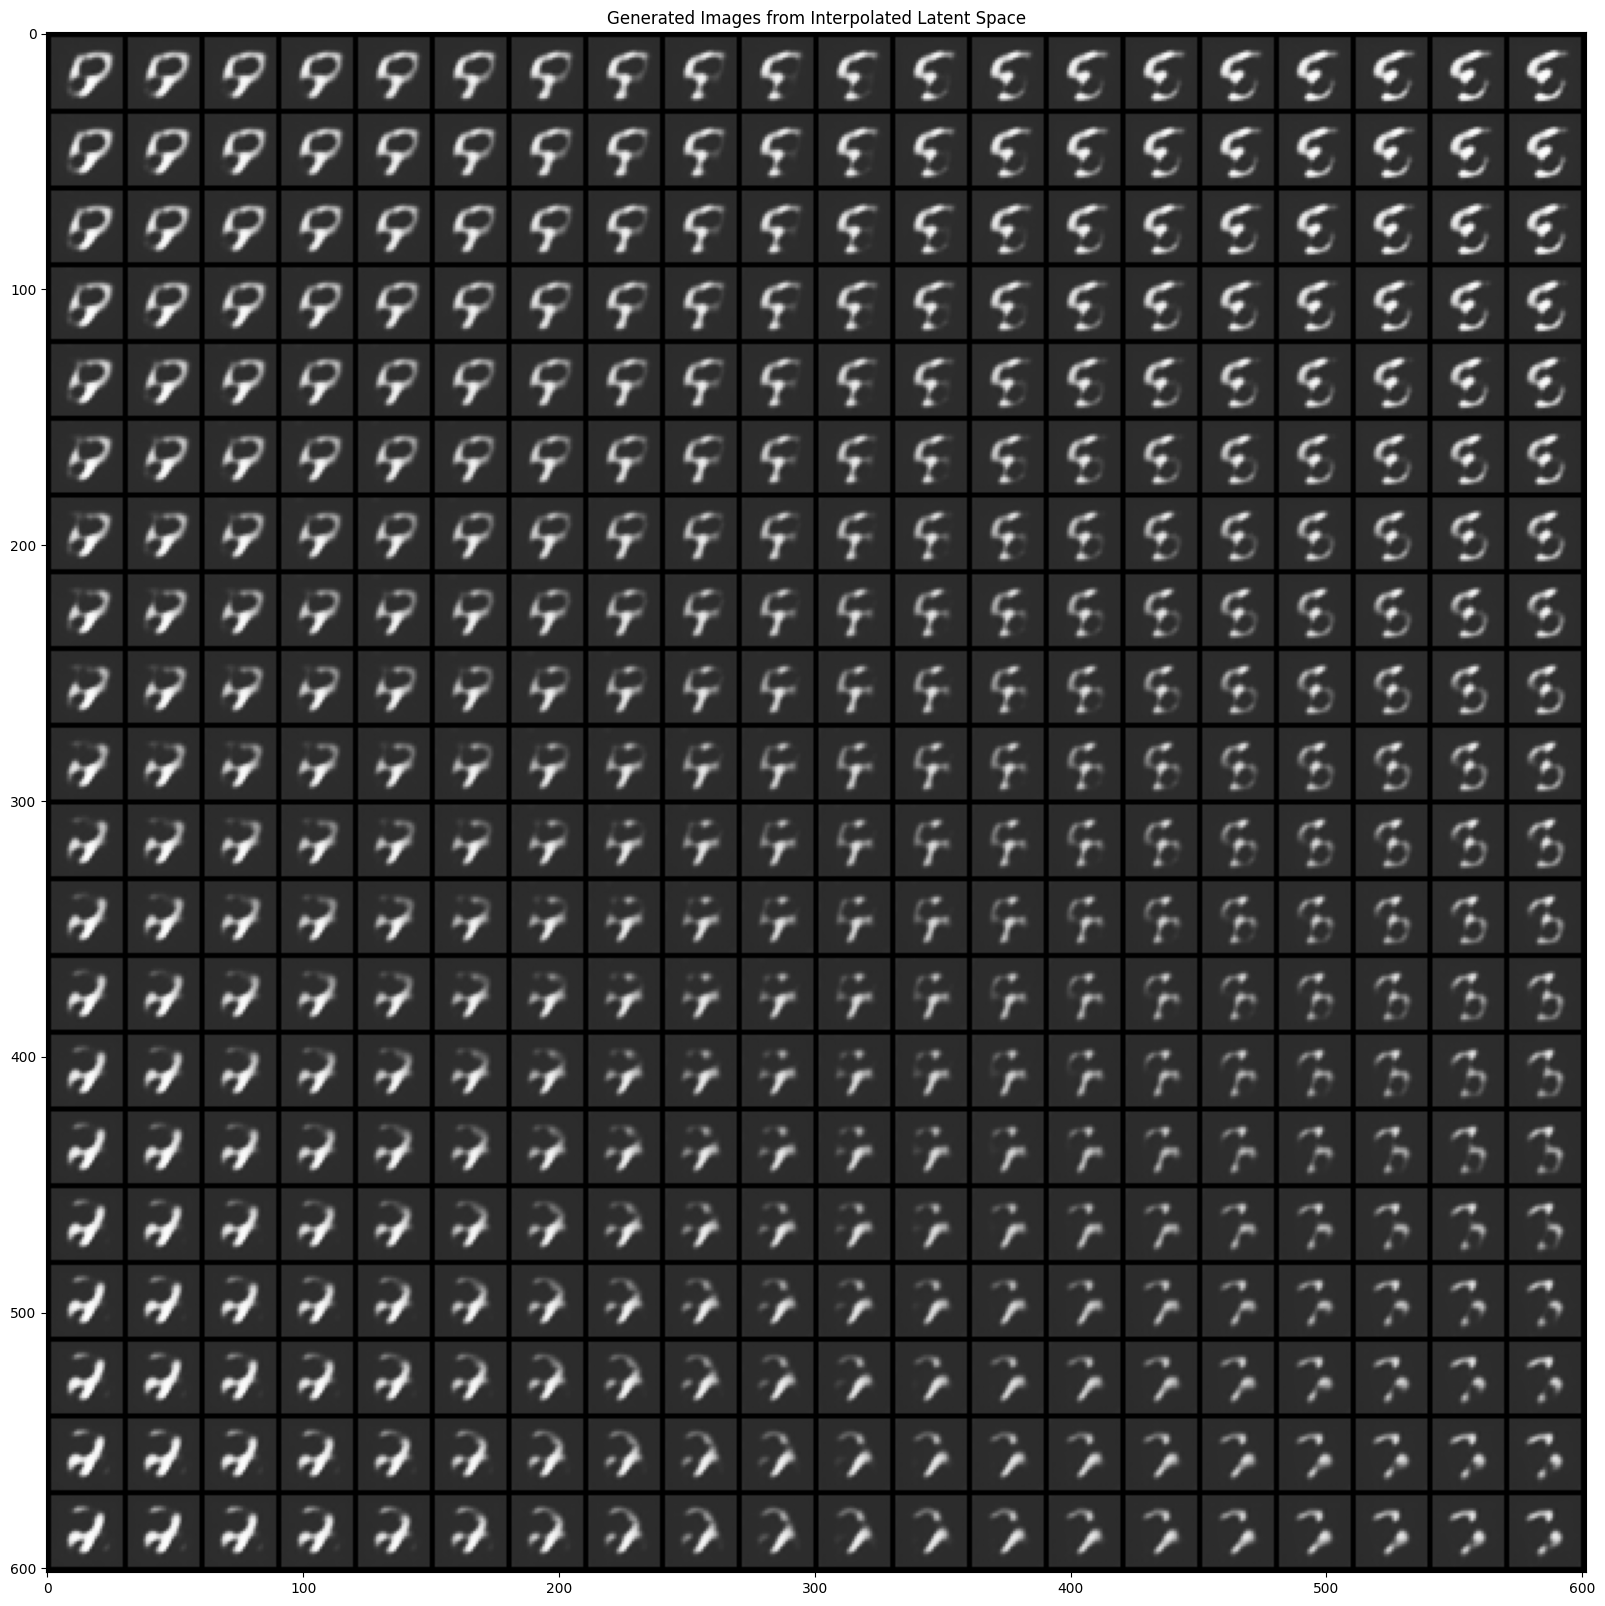

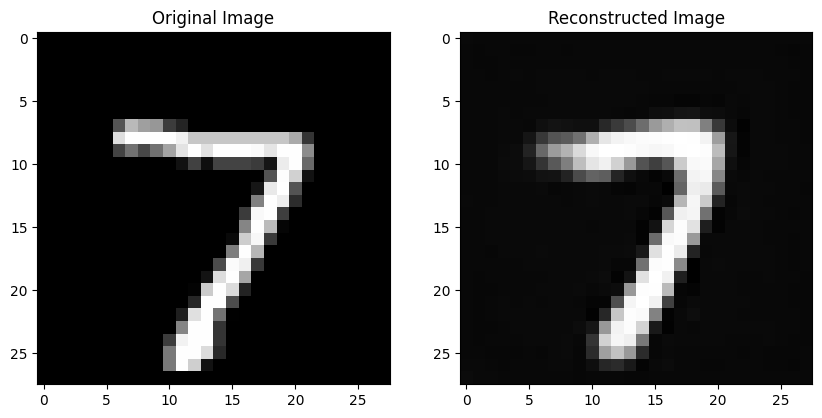

Training with Beta=10
Epoch [1/30], Loss: 1467.5867
Epoch [6/30], Loss: 1290.4724
Epoch [11/30], Loss: 1204.7167
Epoch [16/30], Loss: 1137.1475
Epoch [21/30], Loss: 1080.2501
Epoch [26/30], Loss: 1032.0090


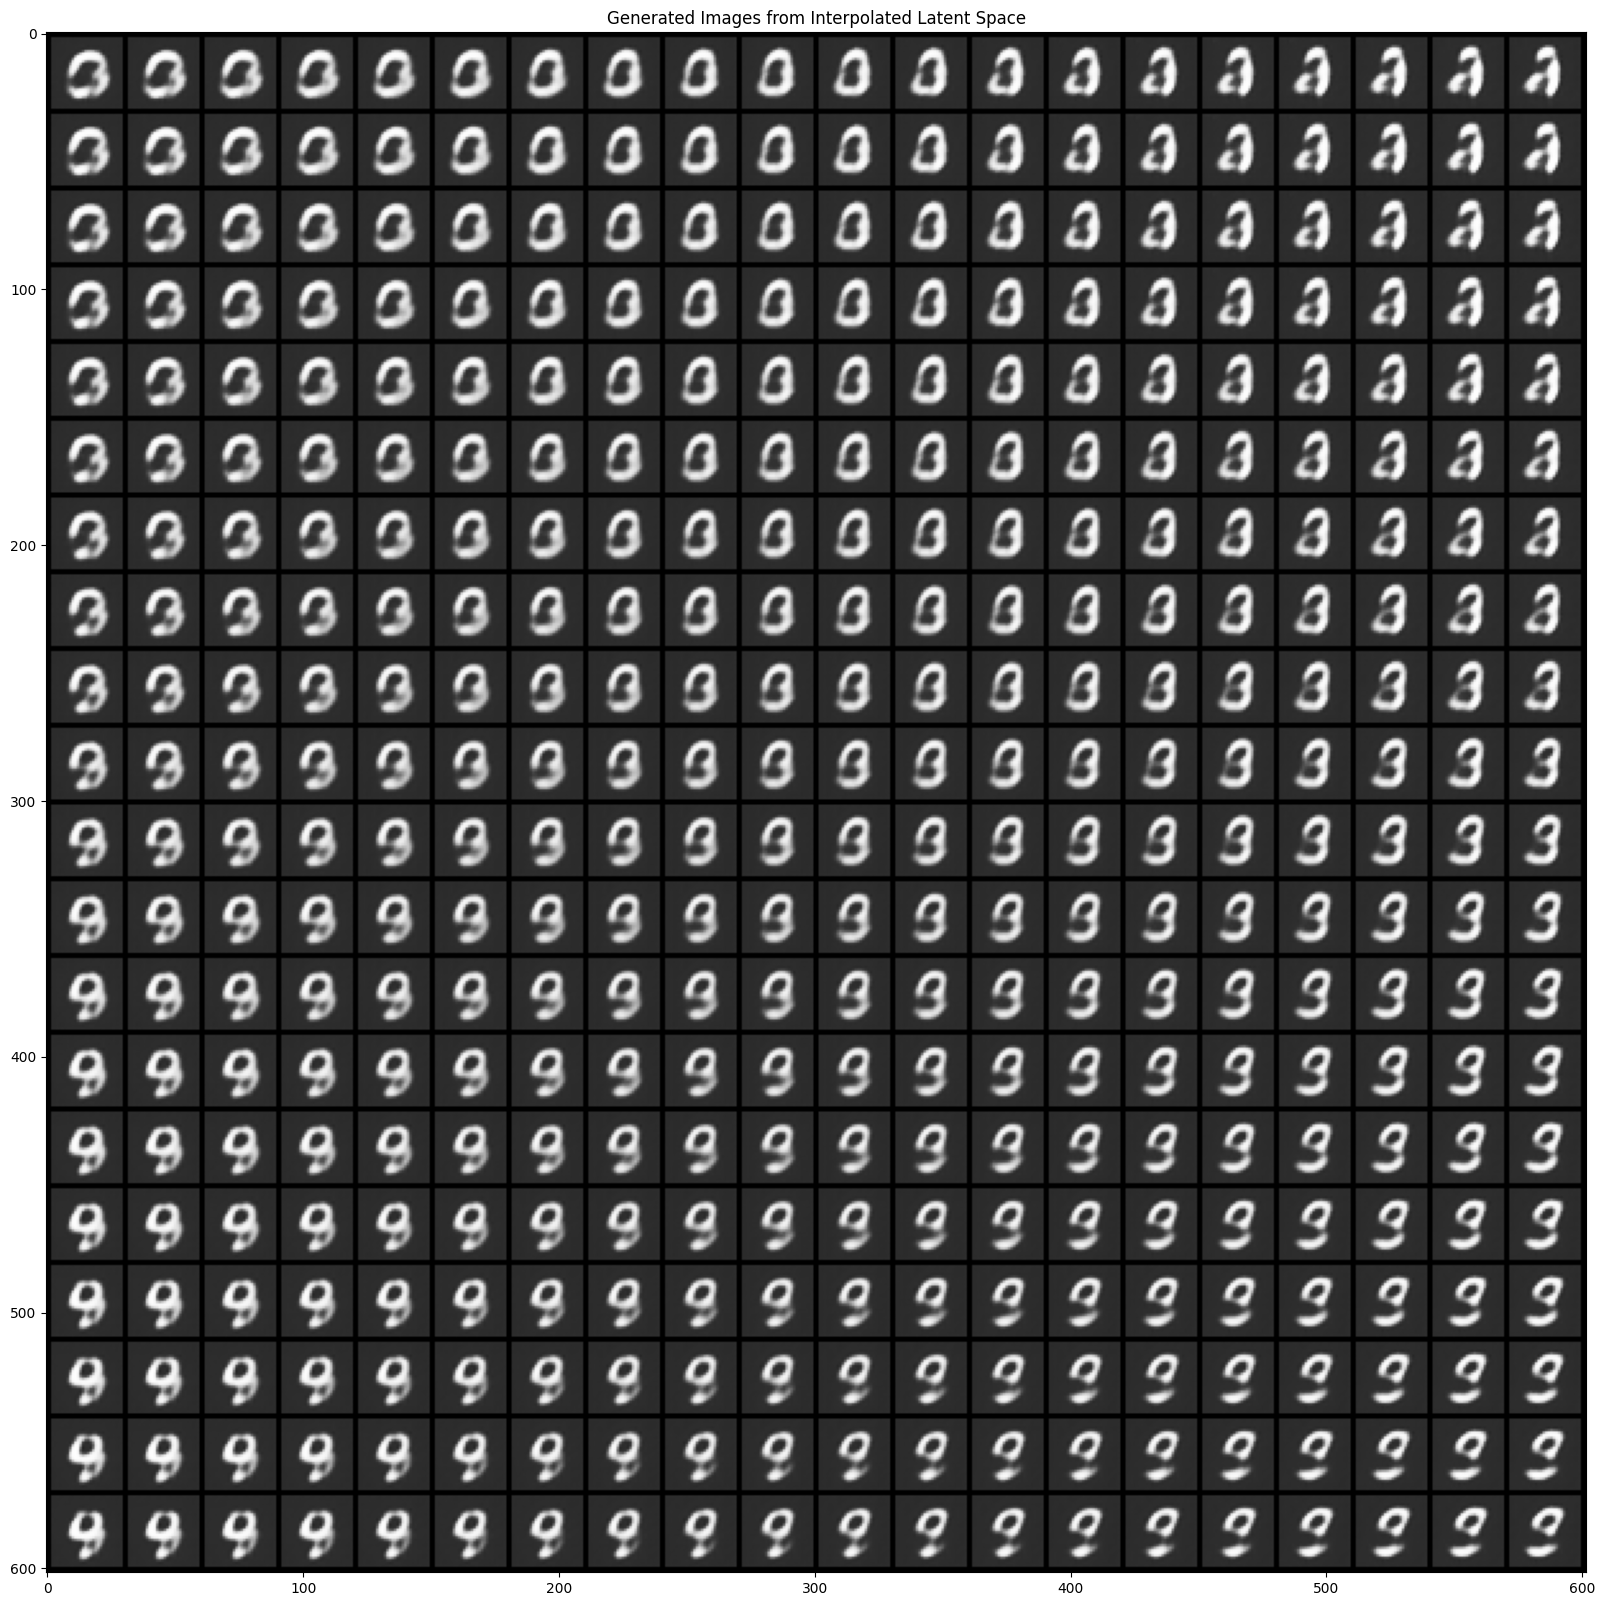

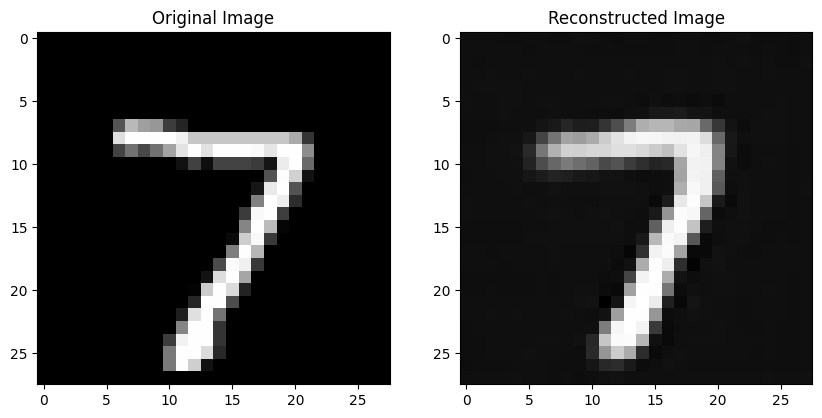

In [3]:
beta_values = [0.1, 2.0, 5.0,10]  # Experimenting with different beta values

for beta in beta_values:
    model = ConvVAE(in_size=28, in_channels=1, latent_dim=latent_dim, hidden_channels=hidden_channels, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print(f"Training with Beta={beta}")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, _ in train_loader:
            images = images.to(device)

            optimizer.zero_grad()
            recon_images, mu, log_var = model(images)

            loss = beta_vae_loss(mu, log_var, recon_images, images, beta=beta)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        if(epoch%5==0):
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss / len(train_loader.dataset):.4f}")
    
    model.eval()
    with torch.no_grad():
        # Step 2: Interpolate between the four points and create a grid
        num_points = 20  # Define how many points to generate between each pair
        grid_points = []
        
        for i in range(num_points):
            alpha = i / (num_points - 1)
            for j in range(num_points):
                beta = j / (num_points - 1)
                # Interpolate between the four corner points
                z = (1 - alpha) * (1 - beta) * z_list[0] + alpha * (1 - beta) * z_list[1] + (1 - alpha) * beta * z_list[2] + alpha * beta * z_list[3]
                grid_points.append(z)
        
        # Step 3: Convert the list of grid points into a tensor
        grid_points = torch.cat(grid_points, dim=0)
        
        # Step 4: Decode the latent vectors into images
        generated_images = model.decode(grid_points).cpu()
        
        # Step 5: Visualize the generated images in a grid
        grid_img = torchvision.utils.make_grid(generated_images, nrow=num_points)
        plt.figure(figsize=(20, 20))
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.title("Generated Images from Interpolated Latent Space")
        plt.show()
        
        # Step 6: Visualize original and reconstructed images from the test set
        sample_image, _ = next(iter(test_loader))
        sample_image = sample_image.to(device)
        
        recon_image, _, _ = model(sample_image)
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(sample_image[0].cpu().squeeze(), cmap='gray')
        ax[0].set_title("Original Image")
        ax[1].imshow(recon_image[0].cpu().squeeze(), cmap='gray')
        ax[1].set_title("Reconstructed Image")
        plt.show()